# Helper functions

In [ ]:
import zipfile
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
from posixpath import pathsep
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir,target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  path=target_folder + "/" + random_image[0]
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  print(f"file name: {random_image[0]}")
  return img,path

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
import tensorflow as tf
def prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

# Explore  data

In [ ]:
unzip_data('drive/MyDrive/10food.zip')

In [ ]:
for dirpath, dirnames, filenames in os.walk("10food"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10food'.
There are 10 directories and 0 images in '10food/train'.
There are 0 directories and 750 images in '10food/train/hamburger'.
There are 0 directories and 750 images in '10food/train/fried_rice'.
There are 0 directories and 750 images in '10food/train/sushi'.
There are 0 directories and 750 images in '10food/train/pizza'.
There are 0 directories and 750 images in '10food/train/chicken_curry'.
There are 0 directories and 750 images in '10food/train/ice_cream'.
There are 0 directories and 750 images in '10food/train/ramen'.
There are 0 directories and 750 images in '10food/train/grilled_salmon'.
There are 0 directories and 750 images in '10food/train/steak'.
There are 0 directories and 750 images in '10food/train/chicken_wings'.
There are 10 directories and 0 images in '10food/test'.
There are 0 directories and 250 images in '10food/test/hamburger'.
There are 0 directories and 250 images in '10food/test/fried_rice'.
There are 0 directories 

Image shape: (512, 512, 3)
file name: 3693649.jpg


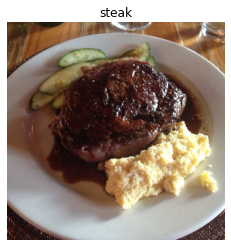

In [ ]:
sample,path=view_random_image('10food/train/','steak')

Image shape: (512, 382, 3)
file name: 220190.jpg


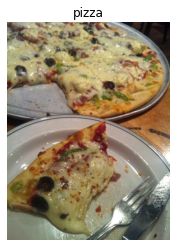

In [ ]:
sample2,path2=view_random_image('10food/train/','pizza')

# Prepare and prefetch dataset

In [ ]:
train_dir = "10food/train"
test_dir = "10food/test"

In [ ]:
train10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              label_mode="categorical",
                                                              image_size=(224,224))
                                                                                
test10 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224,224),
                                                                shuffle=False)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
class_names=train10.class_names
train10, class_names

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [ ]:
# See an example batch of data
#for images, labels in train10.take(1):
#  print(images, labels)

In [ ]:
train10 =train10.prefetch(buffer_size=tf.data.AUTOTUNE)
test10=test10.prefetch(buffer_size=tf.data.AUTOTUNE)
train10, test10

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>)

# Create callbacks

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", 
                                                      save_best_only=True,
                                                      save_weights_only=True, 
                                                      verbose=1)  
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)

## set mixed precision for faster computation (GPU capability of at least 7.0)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5ea71a98-db62-c588-26c4-6fe52461f5ac)


In [ ]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16")
# mixed_precision.global_policy()
# should return <Policy "mixed_float16"> if correctly set 

# Feature extraction model efficientnetb0

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.3),
  preprocessing.RandomZoom(0.3),
  preprocessing.RandomHeight(0.3),
  preprocessing.RandomWidth(0.3),
], name ="data_augmentation")

base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=layers.Input(shape=(224,224,3),name='input_layer',dtype=tf.float32) # if using mixed precision, set to tf.float16
x = data_augmentation(inputs)
x=base_model(x, training=False)
x=layers.Dropout(0.3)(x)
x=layers.GlobalMaxPool2D()(x)
x=layers.Dense(len(class_names))(x)
output=layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)
model=tf.keras.Model(inputs, output)

In [ ]:
model.compile(loss="categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(), 
                        metrics=["accuracy"])

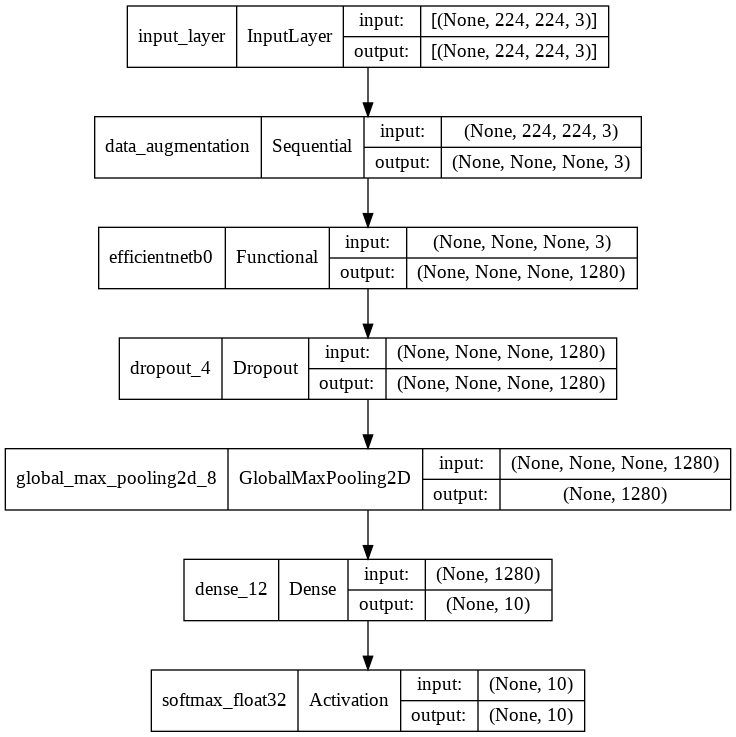

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
history_10food_feature_extract = model.fit(train10, 
                                          epochs=20,
                                           steps_per_epoch=len(train10),
                                           validation_data=test10,
                                           validation_steps=len(test10),
                                          callbacks=[model_checkpoint,early_stop])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 2.4161 - accuracy: 0.4833
Epoch 00001: val_loss did not improve from 0.34155
235/235 [==============================] - 28s 96ms/step - loss: 2.4161 - accuracy: 0.4833 - val_loss: 1.0893 - val_accuracy: 0.7200
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 1.4903 - accuracy: 0.6528
Epoch 00002: val_loss did not improve from 0.34155
235/235 [==============================] - 22s 92ms/step - loss: 1.4903 - accuracy: 0.6528 - val_loss: 0.7498 - val_accuracy: 0.7896
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 1.3106 - accuracy: 0.6868
Epoch 00003: val_loss did not improve from 0.34155
235/235 [==============================] - 22s 91ms/step - loss: 1.3106 - accuracy: 0.6868 - val_loss: 0.8080 - val_accuracy: 0.7888
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 1.2431 - accuracy: 0.7056
Epoch 00004: val_loss did not improve from 0.34155
235/235 [====

In [ ]:
model.evaluate(test10)

79/79 [==============================] - 5s 68ms/step - loss: 0.6662 - accuracy: 0.8028


[0.666217029094696, 0.8027999997138977]

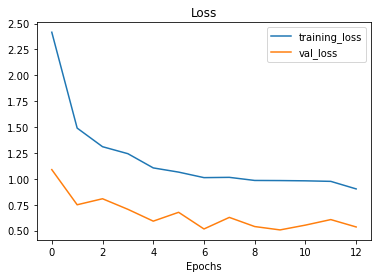

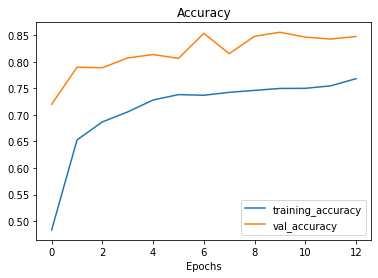

In [ ]:
plot_loss_curves(history_10food_feature_extract)

# Fine tune last 20 layers of base model

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=3,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [ ]:
model.compile(loss="categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(0.0001), 
                        metrics=["accuracy"])

In [ ]:
history_fine_tune=model.fit(train10,
                                  epochs=30,
                                  steps_per_epoch=len(train10),
                                  initial_epoch=history_10food_feature_extract.epoch[-1],
                                  validation_data=test10,
                                  validation_steps=len(test10),
                                  callbacks=[ early_stop, 
                                              reduce_lr]) 

Epoch 13/30
235/235 [==============================] - 29s 99ms/step - loss: 0.6347 - accuracy: 0.8115 - val_loss: 0.3906 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 14/30
235/235 [==============================] - 22s 94ms/step - loss: 0.5151 - accuracy: 0.8356 - val_loss: 0.3756 - val_accuracy: 0.8832 - lr: 1.0000e-04
Epoch 15/30
235/235 [==============================] - 22s 94ms/step - loss: 0.4674 - accuracy: 0.8501 - val_loss: 0.3549 - val_accuracy: 0.8884 - lr: 1.0000e-04
Epoch 16/30
235/235 [==============================] - 23s 95ms/step - loss: 0.4242 - accuracy: 0.8616 - val_loss: 0.3661 - val_accuracy: 0.8784 - lr: 1.0000e-04
Epoch 17/30
235/235 [==============================] - 23s 94ms/step - loss: 0.3743 - accuracy: 0.8739 - val_loss: 0.3564 - val_accuracy: 0.8848 - lr: 1.0000e-04
Epoch 18/30
235/235 [==============================] - 23s 94ms/step - loss: 0.3612 - accuracy: 0.8793 - val_loss: 0.3343 - val_accuracy: 0.8928 - lr: 1.0000e-04
Epoch 19/30
235/235 [=======

In [ ]:
model.evaluate(test10)

79/79 [==============================] - 5s 67ms/step - loss: 0.3734 - accuracy: 0.8840


[0.37344104051589966, 0.8840000033378601]

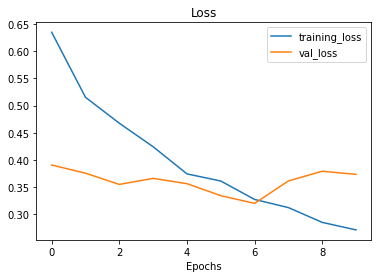

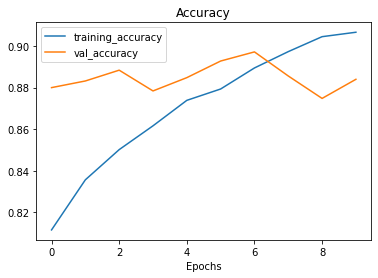

In [ ]:
plot_loss_curves(history_fine_tune)

# Visualize  predictions in the test data

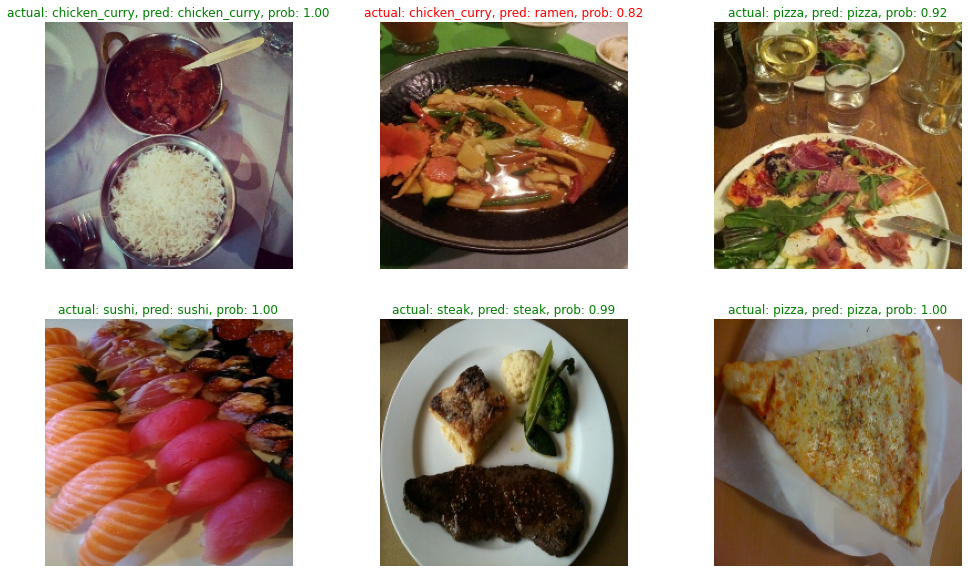

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(6):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir+"/" + class_name + "/" + filename
  img = prep_image(filepath,scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 

  plt.subplot(2, 3, i+1)
  plt.imshow(img/255)
  if class_name == pred_class: 
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Evaluation

In [ ]:
pred = model.predict(test10)
pred_label = pred.argmax(axis=1)

In [ ]:
filepaths = []
for path in test10.list_files("10food/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(path.numpy())

In [ ]:
true_label = []
for images, labels in test10.unbatch(): 
  true_label.append(labels.numpy().argmax())

In [ ]:
import pandas as pd
df = pd.DataFrame({"path": filepaths,
                    "pred_prob": pred.max(axis=1), 
                    "true_label": [class_names[i] for i in true_label],
                    "pred_label": [class_names[i] for i in pred_label]}) 
df["result"] = df["true_label"] == df["pred_label"]
df.head(10)

,path,pred_prob,true_label,pred_label,result
0,b'10food/test/chicken_curry/101833.jpg',0.999596,chicken_curry,chicken_curry,True
1,b'10food/test/chicken_curry/10340.jpg',0.809578,chicken_curry,chicken_curry,True
2,b'10food/test/chicken_curry/1035626.jpg',0.988198,chicken_curry,chicken_curry,True
3,b'10food/test/chicken_curry/1048226.jpg',0.535455,chicken_curry,chicken_curry,True
4,b'10food/test/chicken_curry/1075859.jpg',0.999841,chicken_curry,chicken_curry,True
5,b'10food/test/chicken_curry/1076489.jpg',0.999701,chicken_curry,chicken_curry,True
6,b'10food/test/chicken_curry/108559.jpg',0.998904,chicken_curry,chicken_curry,True
7,b'10food/test/chicken_curry/1095245.jpg',0.979320,chicken_curry,chicken_curry,True
8,b'10food/test/chicken_curry/1125163.jpg',0.999641,chicken_curry,chicken_curry,True
9,b'10food/test/chicken_curry/1134602.jpg',0.997166,chicken_curry,chicken_curry,True


In [ ]:
top_wrong = df[df.result == False].sort_values("pred_prob", ascending=False)
top_wrong.head(10)

,path,pred_prob,true_label,pred_label,result
1602,b'10food/test/pizza/2508636.jpg',0.999360,pizza,hamburger,False
951,b'10food/test/grilled_salmon/3850404.jpg',0.996739,grilled_salmon,steak,False
1096,b'10food/test/hamburger/258503.jpg',0.996422,hamburger,steak,False
590,b'10food/test/fried_rice/2150469.jpg',0.994736,fried_rice,chicken_curry,False
57,b'10food/test/chicken_curry/1707089.jpg',0.994629,chicken_curry,chicken_wings,False
1039,b'10food/test/hamburger/1611759.jpg',0.993895,hamburger,steak,False
645,b'10food/test/fried_rice/285785.jpg',0.993818,fried_rice,chicken_curry,False
2463,b'10food/test/sushi/684266.jpg',0.993557,sushi,steak,False
728,b'10food/test/fried_rice/69248.jpg',0.993005,fried_rice,chicken_curry,False
138,b'10food/test/chicken_curry/2922076.jpg',0.992435,chicken_curry,ramen,False


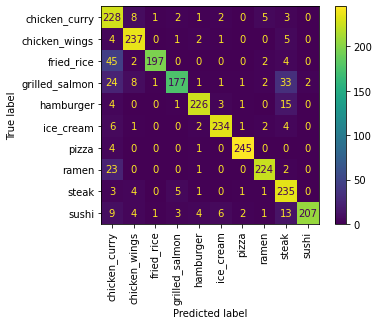

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)
disp.plot()
plt.xticks(rotation='vertical')
plt.show()

# Predict on new photos downloaded from internet

In [ ]:
unzip_data("drive/MyDrive/real photo.zip")

In [ ]:
food_path= ["real photo/" + path for path in os.listdir("real photo")][:7]
food_path

['real photo/sushi.jpg',
 'real photo/hamburger.jpg',
 'real photo/ramen.jpg',
 'real photo/salmon.jpg',
 'real photo/icecream.jpg',
 'real photo/steak.jpg',
 'real photo/sushi2.jpg']

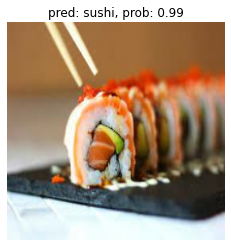

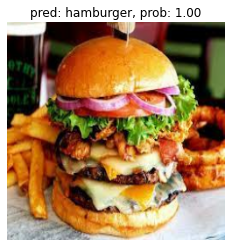

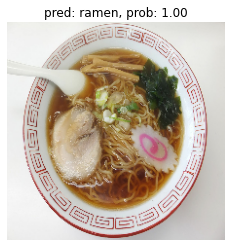

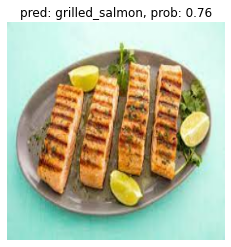

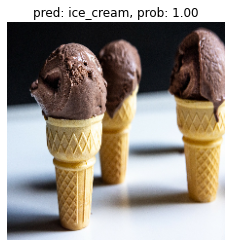

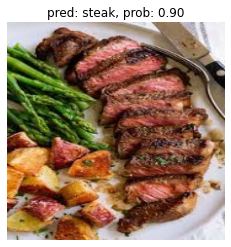

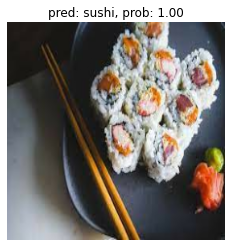

In [ ]:
for img in food_path:
  img = prep_image(img,scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] 
  plt.figure()
  plt.imshow(img/255) 
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)